# Convolutional Neural Network
---

![Cnn](../picture/CNN.jpeg)

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.[Soure](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

![A CNN sequence to classify handwritten digits](../picture/1_uAeANQIOQPqWZnnuH-VEyw.jpeg )
---

In [1]:
# Import librarys
# normal 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# open file
from IPython.display import Image
import os
import PIL

# model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Create function plot loss function and accuracy score graph
def plot_graph(model_values):
    ''' 
    Input : Model_values of keras.callbacks.History
    Return : Graph of Loss function and accuracy score between training dataset and vaildation dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss');
    plt.plot(model_values.history['val_loss'], label='Testing Loss');
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot MSE
    plt.subplot(1, 2, 2)
    
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy');

### 00 First, check GPU.
---

In [1]:
# https://www.tensorflow.org/guide/keras/sequential_model
# Due to we use Keras Sequential API, 
# We want to check GPU first before training our model for 
# impore efficiency and reduce time. 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9463075407103348749
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914307278
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12848595813416166211
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


### 01 Open datasets
---

In [4]:
# Open path file of dataset 
# We prepare actucl diretories form to training in 01.Preprocessing datasets notebook
dataset_path_new = "dataset_train_valid_test"

train_dir = os.path.join(dataset_path_new, "train")
valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

### 02 Preprocessing image dataset 
---

In [5]:
# Set parameter of image 
# We use input small size image because reduce size of model 
batch_size = 50 # Set the batch size for epoch cycle
img_height = 128 # Set the height of the picture
img_width = 128 # Set the width of the picture

# Rescale pixel to reduce image size before using in model
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

In [6]:
# Create training dataset 
train_dataset = data_gen_train.flow_from_directory(train_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)
 

# Create validation dataset 
valid_dataset = data_gen_valid.flow_from_directory(valid_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

# Create testing dataset 
test_dataset = data_gen_test.flow_from_directory(test_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)


Found 7796 images belonging to 4 classes.
Found 816 images belonging to 4 classes.
Found 805 images belonging to 4 classes.


In [7]:
# Classes in training dataset
print(pd.Series(train_dataset.classes).value_counts(normalize = True).mul(100))
print(train_dataset.class_indices)

3    26.885582
0    25.615700
1    24.409954
2    23.088763
dtype: float64
{'cocci': 0, 'healthy': 1, 'ncd': 2, 'salmo': 3}


In [8]:
# Classes in validation dataset
pd.Series(valid_dataset.classes).value_counts()
# Class 0 : cocci
# Class 1 : healthy
# Class 2 : ncd 
# Class 3 : salmo

1    276
0    247
3    239
2     54
dtype: int64

In [9]:
# Classes in training dataset
pd.Series(test_dataset.classes).value_counts()

3    290
0    232
1    225
2     58
dtype: int64

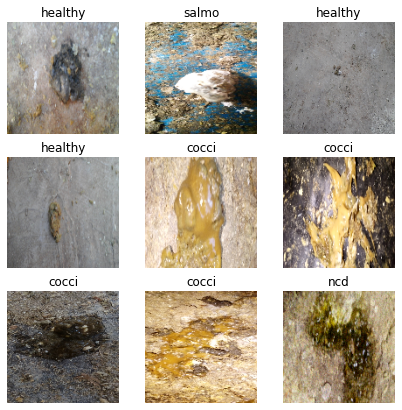

In [10]:
# show some image sample in training dataset
images, labels_class = next(train_dataset)
classes = train_dataset.class_indices
plt.figure(figsize=(7, 7))
for i in range(9):
    label = [j for j in classes if classes[j] == np.argmax(labels_class[i])][0]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i]*255.).astype("uint8"))
    plt.title(label)
    plt.axis("off")

In [11]:
# Recheck after rescale
print(images[0].max())
print(images[0].min())

1.0
0.08627451


---

### 03 CNN model training 
---

In [12]:
# Training model
# Compile the model
model = Sequential()

# Input layer
model.add(Conv2D(16,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same', input_shape=(128,128,3))) # filter image by dot product in matrix to find the object in picture
# Hidden layers
model.add(MaxPooling2D(pool_size=(2,2))) # reduce stucture of image even if object slightly move but the result is same  
model.add(Conv2D(32,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # convert all the resultant 2-Dimensional arrays into a single long continuous linear vector
model.add(Dense(64, activation='relu',
                kernel_initializer='he_uniform'))

# avoid overfitting!
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model         
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [13]:
# we have 2,102,564 nodes for training
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2

In [14]:
# Save checkpoints during training
checkpoint_path = "../model/cnn/cnn_model_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
# training model 
# make sure you truely save checkpoint_path
history = model.fit(train_dataset,
                              epochs=25,
                              validation_data=valid_dataset,
                              callbacks=[cp_callback])

Epoch 1/25
156/156 [==============================] - ETA: 0s - loss: 1.3078 - accuracy: 0.4985 
Epoch 1: saving model to /content/drive/MyDrive/cnn_model_ck/cp.ckpt
156/156 [==============================] - 4921s 31s/step - loss: 1.3078 - accuracy: 0.4985 - val_loss: 0.8214 - val_accuracy: 0.7230
Epoch 2/25
156/156 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.6779
Epoch 2: saving model to /content/drive/MyDrive/cnn_model_ck/cp.ckpt
156/156 [==============================] - 615s 4s/step - loss: 0.8206 - accuracy: 0.6779 - val_loss: 0.6573 - val_accuracy: 0.7451
Epoch 3/25
156/156 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.7463
Epoch 3: saving model to /content/drive/MyDrive/cnn_model_ck/cp.ckpt
156/156 [==============================] - 613s 4s/step - loss: 0.6677 - accuracy: 0.7463 - val_loss: 0.5418 - val_accuracy: 0.8174
Epoch 4/25
156/156 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.7923
Epoch 4: s

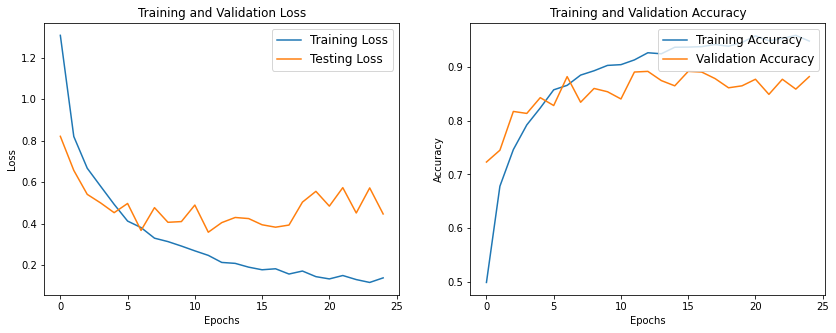

In [ ]:
# plot graph 
plot_graph(history)

# Slightly overfit between training and validation 
# Final accuracy after training 25 epochs is score in training 0.94% 
# and vaildaion 0.88%
# Loss function after training 25 epochs is score in training 0.14% 
# and vaildaion 0.45%

# Good performance! but not enough !  

In [ ]:
# create dataframe to save in .csv file
hist_df = pd.DataFrame(history.history) 
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.307840,0.498461,0.821401,0.723039
1,0.820596,0.677912,0.657307,0.745098
2,0.667660,0.746280,0.541760,0.817402
3,0.580296,0.792329,0.500250,0.813725
4,0.493697,0.823884,0.453565,0.843137


In [ ]:
# save model
model.save("../model/cnn/cnn_model.h5")

In [ ]:
# save history our model to csv: 
hist_csv_file = '../model/cnn/history_cnn16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

---